<a href="https://colab.research.google.com/github/jplulu/Frequentist-ML/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# South African Heart Disease Dataset Analysis

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import math

In [92]:
# -----------------Using South African heart disease dataset from the book

# Read data
df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/SAheart.csv', sep=',').drop(['row.names'],axis=1)

# Convert famhist column so that Present = 1 and Absent = 0
df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})

In [93]:
# ----------------- Preprocess data

# Shuffle data
np.random.seed(652)
df_shuffle = df.sample(frac=1)
df_x = df_shuffle.drop(['chd'], axis=1)
df_y = df_shuffle['chd']

# Standardizing predictors to zero mean unit variance
df_x = (df_x - df_x.mean()) / df_x.std()

# Added ones column for intercept
ones_col = np.ones(len(df_x))
df_x.insert(0, "intercept", ones_col)

# Separate training, validation, and testing data
x_train, x_val, x_test = np.split(df_x, [int(0.8*len(df_x)), int(0.9*len(df_x))])
y_train, y_val, y_test = np.split(df_y, [int(0.8*len(df_y)), int(0.9*len(df_y))])

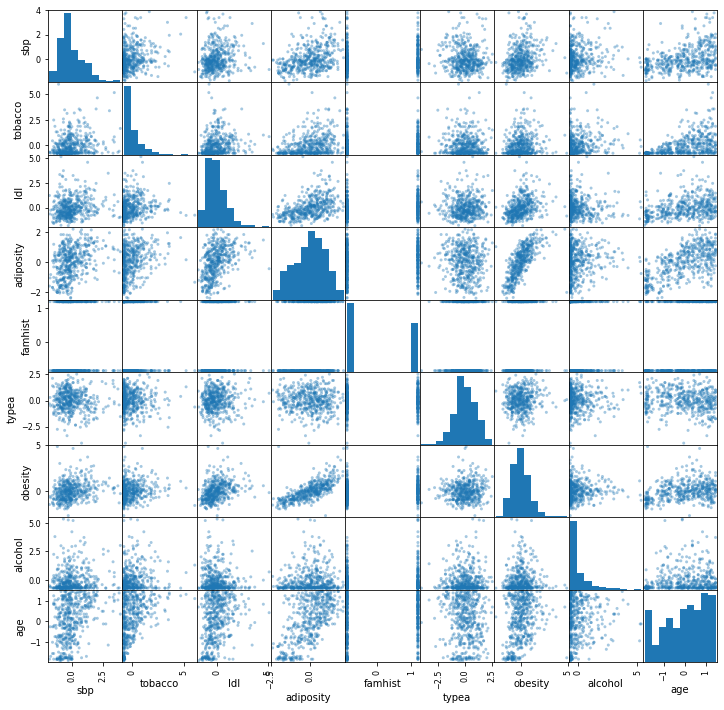

In [94]:
# Plot Figure 4.12
scatter_matrix = pd.plotting.scatter_matrix(df_x.drop(['intercept'], axis=1), alpha=0.4, figsize=(12,12))

# Unregularized Logistic Regression

In [95]:
# Sigmoid function: g(z) = 1 / 1 + e^-z
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Logistic regression with no regularization to calculate theta
def logistic_noreg(x_train, y_train, num_steps, learning_rate):
  # Initialize theta to zeros
  theta = np.zeros(len(x_train.columns))

  # Stochastic gradient descent over num_steps
  for step in range(num_steps):
    z = np.dot(x_train, np.transpose(theta))
    h = sigmoid(z)

    gradient = np.dot((y_train - h), x_train)
    theta += learning_rate * gradient
  
  return theta

In [96]:
num_steps = 10000
learning_rate = 0.01

# Calulate theta using train data
theta_noreg = logistic_noreg(x_train, y_train, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_test, np.transpose(theta_noreg))
pred_noreg = np.round(sigmoid(z_test))
acc_noreg = (pred_noreg == y_test).sum().astype(np.float128) / len(pred_noreg)
print ('Accuracy with no regularization: {0}'.format(acc_noreg))

Accuracy with no regularization: 0.851063829787234


# Logistic Regression with L2 Regularization

In [97]:
# Logistic regression with L2 regularization to calculate theta
def logistic_reg_l2(x_train, y_train, x_val, y_val, lam_vec, num_steps, learning_rate):
  opt_lambda = None
  accuracy = 0.0
  theta_reg = []

  for l in lam_vec:
    theta = np.zeros(len(x_train.columns))

    # Stochastic gradient descent over num_steps
    for step in range(num_steps):
      z = np.dot(x_train, np.transpose(theta))
      h = sigmoid(z)

      gradient = np.dot((y_train - h), x_train)
      # Add penalty to update function
      # https://stats.stackexchange.com/questions/259752/sgd-l2-penalty-weights-update
      theta += learning_rate * gradient - 2 * l * theta

    z_val = np.dot(x_val, np.transpose(theta))
    pred = np.round(sigmoid(z_val))
    acc_reg = (pred == y_val).sum().astype(np.float128) / len(pred)

    # Save lambda if better acc
    if acc_reg > accuracy:
      opt_lambda = l
      accuracy = acc_reg
      theta_reg = theta
    
  return theta_reg, opt_lambda

In [98]:
num_steps = 5000
learning_rate = 0.02
lam_vec = np.linspace(0,0.5,num=100)

# Calulate theta using train data
theta_reg, opt_lambda = logistic_reg_l2(x_train, y_train, x_val, y_val, lam_vec, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_test, np.transpose(theta_reg))
pred_reg = np.round(sigmoid(z_test))
acc_reg = (pred_reg == y_test).sum().astype(np.float128) / len(pred_reg)
print('Accuracy with l2 regularization: {0} '.format(acc_reg))
print('With theta {0}'.format(theta_reg))

Accuracy with l2 regularization: 0.8936170212765957 
With theta [-1.35338553  0.21661787  0.46406731  0.399651   -0.01125878  0.46533212
  0.56613798 -0.36355455 -0.03166888  0.47467721]


L2 regularization was able to achieve better accuracy than no regularization

# Stepwise Logistic Regression

In [99]:
# Logistic regression with foward stepwise and cross validation to determine best features
def forward_stepwise(x_train, y_train, x_val, y_val, num_steps, learning_rate, DEBUG=False):
  all_features = range(x_train.shape[1])
  # Create null model
  retained_feature = [0]
  chosen_models = []

  for f in all_features:
    # If beta0, skip
    if f == 0:
      continue

    # Get list of features not yet used (get unique elements between both lists)
    features_left = list(set(all_features).symmetric_difference(set(retained_feature)))
    if DEBUG:
      print('\nRetained features' + str(retained_feature))
      print('Features left '+ str(features_left))
    
    accuracy = 0
    best_feat = -1
    for feat in features_left:
      # Try [previous model + new_feature]
      model_features = retained_feature + [feat]   
      if DEBUG: 
        print('Testing with features '+ str(model_features))
    
      x_trainfeature = x_train.iloc[:,model_features]
      x_valfeat = x_val.iloc[:,model_features]
    
      theta_noreg = logistic_noreg(x_trainfeature, y_train, num_steps, learning_rate)   

      # Calculate predictions on test data
      z_test = np.dot(x_valfeat, np.transpose(theta_noreg))
      pred_noreg = np.round(sigmoid(z_test))
      acc_noreg = (pred_noreg == y_val).sum().astype(float) / len(pred_noreg)

      # Decide whether or not to keep feature based on if accuracy improved
      if acc_noreg > accuracy:
        best_feat = feat
        accuracy = acc_noreg

    retained_feature.append(best_feat)
    chosen_models.append((retained_feature.copy(), accuracy))

  # Using numpy, sort by accuracy. Choose tuple with largest accuracy.
  best_model = chosen_models[np.argsort(np.array(chosen_models)[:,1])[-1]]
  
  return best_model[0], best_model[1]

In [101]:
num_steps = 1000
learning_rate = 0.02
model_features, model_acc = forward_stepwise(x_train, y_train, x_val, y_val, num_steps, learning_rate)

# Calculate theta using selected features
x_trainfeature = x_train.iloc[:,model_features]
x_testfeat = x_test.iloc[:,model_features]
theta_noreg = logistic_noreg(x_trainfeature, y_train, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_testfeat, np.transpose(theta_noreg))
pred_noreg = np.round(sigmoid(z_test))
acc_step = (pred_noreg == y_test).sum().astype(float) / len(pred_noreg)

# Output Formatting
col_name = x_val.columns.tolist()
chosen_features = []
for f in model_features:
    chosen_features.append(col_name[f])

print('The best model chosen had the features: {0} and an accuracy of \n    [{1}] against the validation data \n    [{2}] against the testing data '.format(chosen_features,model_acc,acc_step))


The best model chosen had the features: ['intercept', 'age', 'obesity', 'famhist', 'typea'] and an accuracy of 
    [0.782608695652174] against the validation data 
    [0.8085106382978723] against the testing data 


With a seed of 652, the model chose ['intercept', 'age', 'obesity', 'famhist', 'typea'] for its features with an accuracy of 0.7826086 against the validation data and 0.808510 against the testing data. 

With a seed of 654, the model chose ['intercept', 'ldl', 'tobacco', 'famhist', 'sbp', 'alcohol'] for the features. Accuracy against the validation set was 0.8043478 while the testing set was 0.8510638.

Based off the results from different seeds, it is likely that by testing a large range of seeds, the chosen coefficients can be copied.

In [102]:
# Create table comparing accuracy of the three models
acc_types = list(['No regularization','L2 regularization','Forward Stepwise'])
table_acc = pd.DataFrame(list(zip(acc_types, [acc_noreg, acc_reg, acc_step])), columns = ['Logistic Regression','Accuracy'])
display(table_acc)

,Logistic Regression,Accuracy
0,No regularization,0.851064
1,L2 regularization,0.893617
2,Forward Stepwise,0.808511


The table shows the various accuracies of the models used to fit the data. Logistic regression without regularization had better performance than foward stepwise via cross validation while L2 regularization has the best performance against the test dataset. Results fluctuated depending on the seed used which can be attributed to the size of the dataset which meant outliers in the data had a larger effect on the resulting coefficients.

# Stretch Goal 1 - L1 Regularization

In [103]:
# Logistic regression with L1 regularization to calculate theta
def logistic_reg_l1(x_train, y_train, x_val, y_val, lam_vec, num_steps, learning_rate):
  opt_lambda = None
  accuracy = 0.0
  theta_reg = []
  
  # Initialize coefficient array for plotting
  lasso_graph_vec = np.zeros((len(lam_vec), x_train.shape[1]))

  for index, l in enumerate(lam_vec):
    theta = np.zeros(len(x_train.columns))

    # Stochastic gradient descent over num_steps
    for step in range(num_steps):
      z = np.dot(x_train, np.transpose(theta))
      h = sigmoid(z)

      gradient = np.dot((y_train - h), x_train)
      # Add penalty to update function
      theta += learning_rate * gradient

      # Add l1 regularization according to https://www.aclweb.org/anthology/P09-1054.pdf
      for i, t in enumerate(theta):
        if theta[i] > 0:
          theta[i] = max(0, theta[i] - l * learning_rate)
        elif theta[i] < 0:
          theta[i] = min(0, theta[i] + l * learning_rate)

    # Save the coefficients for plotting
    lasso_graph_vec[index,:] = theta

    # Cross validate against validation dataset
    z_val = np.dot(x_val, np.transpose(theta))
    pred = np.round(sigmoid(z_val))
    acc_reg = (pred == y_val).sum().astype(np.float128) / len(pred)

    # Save lambda if better acc
    if acc_reg > accuracy:
      opt_lambda = l
      accuracy = acc_reg
      theta_reg = theta
    
  return theta_reg, opt_lambda, lasso_graph_vec

In [105]:
num_steps = 5000
learning_rate = 0.1
lam_vec = np.linspace(0,5,num=50)

# Calulate theta using train data
theta_l1, opt_lambda, lasso_graph_vec = logistic_reg_l1(x_train, y_train, x_val, y_val, lam_vec, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_test, np.transpose(theta_l1))
pred_l1 = np.round(sigmoid(z_test))
acc_l1 = (pred_reg == y_test).sum().astype(np.float128) / len(pred_l1)
print('Accuracy with l1 regularization: {0} '.format(acc_l1))
print('With theta {0}'.format(theta_l1))

# Find included and excluded features
lasso_features = [i for i in x_train.columns[theta_l1 != 0]]
lasso_excluded_features = list(set(x_train.columns.values)-set(lasso_features))
print("Features included by lasso method:", lasso_features)
print("Features excluded by lasso method:", lasso_excluded_features)

Accuracy with l1 regularization: 0.8936170212765957 
With theta [-5.15272657  1.58314923  3.15095198  3.0721926   1.67814983  2.77422339
  3.06696504 -1.80005809  0.          3.1161149 ]
Features included by lasso method: ['intercept', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'age']
Features excluded by lasso method: ['alcohol']


L1 reguarization excluded alcohol as the only feature. The stepwise model also excluded alcohol as a feature but it also exclude a few others. This is likely due to some sort of discrepency within the data but it is safe to say that alcohol is not a very strong feature as it was excluded by both models.

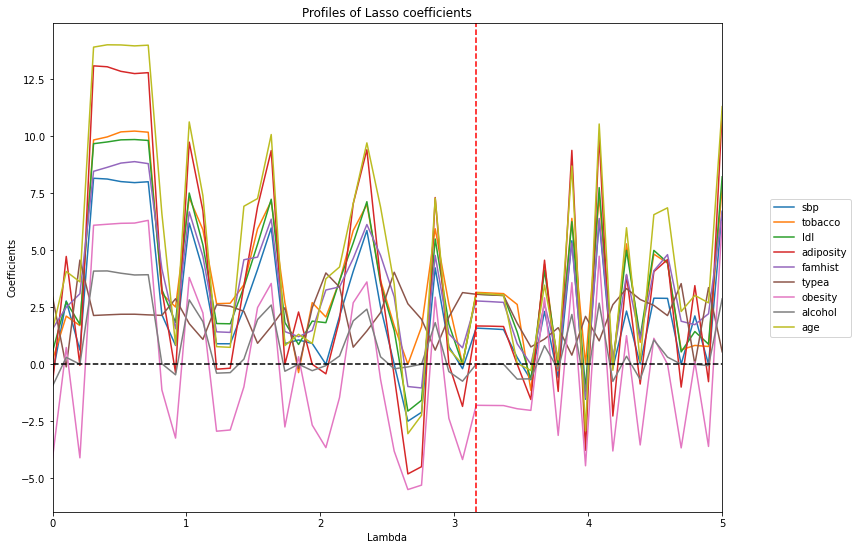

In [106]:
# Plot lambda vs coefficients for each feature
fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, lasso_graph_vec[:,index])
plt.plot((0,5), (0,0), 'k--')
plt.axvline(opt_lambda, 0, 1, linestyle="--", color='red')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of Lasso coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Lambda')
plt.xlim([0,5])
plt.show()

In [107]:
# Create table comparing accuracy of the four models
acc_types = list(['No regularization','L2 regularization','Forward Stepwise', 'L1 regularization'])
table_acc = pd.DataFrame(list(zip(acc_types, [acc_noreg, acc_reg, acc_step, acc_l1])), columns = ['Logistic Regression','Accuracy'])
display(table_acc)

,Logistic Regression,Accuracy
0,No regularization,0.851064
1,L2 regularization,0.893617
2,Forward Stepwise,0.808511
3,L1 regularization,0.893617


L1 regularization was able to achieve better accuracy than no regularization and forward stepwise. Its accuracy was able to match L2 regularization at 89%

# Heart Disease Data Analysis

https://www.kaggle.com/ronitf/heart-disease-uci

This dataset predicts heart disease in a person based on a number of features

Features:

*   age
*   sex
*   cp - chest pain type
*   trestbps - resting blood pressure (in mm Hg on admission to the hospital)
*   chol - serum cholestoral in mg/dl
*   fbs - fasting blood sugar
*   restecg - resting electrocardiographic results
*   thalach - maximum heart rate achieved
*   exang - exercise induced angina
*   oldpeak - ST depression induced by exercise relative to rest
*   slope - the slope of the peak exercise ST segment
*   ca - number of major vessels colored by flourosopy
*   thal

In [108]:
# -----------------Load custom data

df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/heart.csv')
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [109]:
# ----------------- Preprocess data

# Shuffle data
np.random.seed(31431)
df_shuffle = df.sample(frac=1)
df_x = df_shuffle.drop(['target'], axis=1)
df_y = df_shuffle['target']

# Standardizing predictors to zero mean unit variance
df_x = (df_x - df_x.mean()) / df_x.std()

# Added ones column for intercept
ones_col = np.ones(len(df_x))
df_x.insert(0, "intercept", ones_col)

# Separate training, validation, and testing data
x_train, x_val, x_test = np.split(df_x, [int(0.8*len(df_x)), int(0.9*len(df_x))])
y_train, y_val, y_test = np.split(df_y, [int(0.8*len(df_y)), int(0.9*len(df_y))])

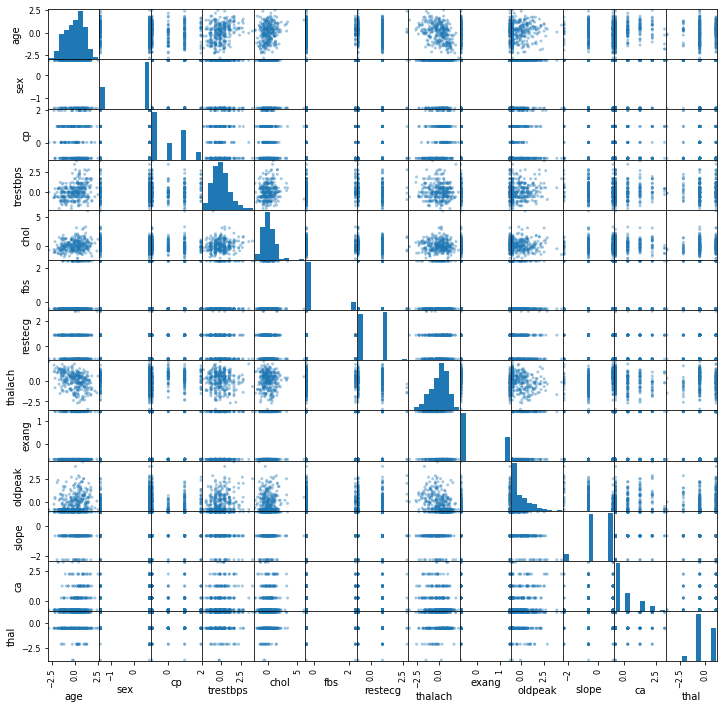

In [110]:
# Plot Figure 4.12
scatter_matrix = pd.plotting.scatter_matrix(df_x.drop(['intercept'], axis=1), alpha=0.4, figsize=(12,12))

In [111]:
num_steps = 5000
learning_rate = 0.1

# Calulate theta using train data
theta_noreg = logistic_noreg(x_train, y_train, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_test, np.transpose(theta_noreg))
pred_noreg = np.round(sigmoid(z_test))
acc_noreg = (pred_noreg == y_test).sum().astype(np.float128) / len(pred_noreg)
print ('Accuracy with no regularization: {0}'.format(acc_noreg))

Accuracy with no regularization: 0.8064516129032258


In [112]:
num_steps = 5000
learning_rate = 0.09
lam_vec = np.linspace(0,0.5,num=100)

# Calulate theta using train data
theta_reg, opt_lambda = logistic_reg_l2(x_train, y_train, x_val, y_val, lam_vec, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_test, np.transpose(theta_reg))
pred_reg = np.round(sigmoid(z_test))
acc_reg = (pred_reg == y_test).sum().astype(np.float128) / len(pred_reg)
print('Accuracy with l2 regularization: {0} '.format(acc_reg))
print('With theta {0}'.format(theta_reg))

Accuracy with l2 regularization: 0.8387096774193549 
With theta [ 1.00827768  0.81222322 -2.72018109  2.96229079 -0.0707414  -0.18040454
  0.2801311   0.03033503  0.62615461 -1.39174686 -1.44236826 -0.04701051
 -1.75023875 -1.99845337]


L2 regularization was able to achieve better accuracy than no regularization

In [122]:
num_steps = 1000
learning_rate = 0.09
model_features, model_acc = forward_stepwise(x_train, y_train, x_val, y_val, num_steps, learning_rate)

# Calculate theta using selected features
x_trainfeature = x_train.iloc[:,model_features]
x_testfeat = x_test.iloc[:,model_features]
theta_noreg = logistic_noreg(x_trainfeature, y_train, num_steps, learning_rate)

# Calculate predictions on test data
z_test = np.dot(x_testfeat, np.transpose(theta_noreg))
pred_noreg = np.round(sigmoid(z_test))
acc_step = (pred_noreg == y_test).sum().astype(float) / len(pred_noreg)

# Output Formatting
col_name = x_val.columns.tolist()
chosen_features = []
for f in model_features:
    chosen_features.append(col_name[f])

print('\nThe best model chosen had the features: {0} and an accuracy of \n    [{1}] against the validation data \n    [{2}] against the testing data '.format(chosen_features,model_acc,acc_step))


The best model chosen had the features: ['intercept', 'slope', 'oldpeak', 'chol', 'exang', 'ca', 'cp', 'fbs', 'sex', 'restecg', 'age'] and an accuracy of 
    [0.8333333333333334] against the validation data 
    [0.8064516129032258] against the testing data 


The model chose the following features: ['intercept', 'slope', 'oldpeak', 'chol', 'exang', 'ca', 'cp', 'fbs', 'sex', 'restecg', 'age'] and exclude the following features: ['trestbps', 'thalach', 'thal']. Based on this, it can be seen that trestbps, thalach, and thal do not have significant impact on the label. 

In [124]:
# Create table comparing accuracy of the three models
acc_types = list(['No regularization','L2 regularization','Forward Stepwise'])
table_acc = pd.DataFrame(list(zip(acc_types, [acc_noreg, acc_reg, acc_step])), columns = ['Logistic Regression','Accuracy'])
display(table_acc)

,Logistic Regression,Accuracy
0,No regularization,0.806452
1,L2 regularization,0.838710
2,Forward Stepwise,0.806452


The table shows the various accuracies of the models used to fit the data. Logistic regression without regularization had the same performance as foward stepwise via cross validation while L2 regularization has the best performance against the test dataset. Results fluctuated depending on the seed used which can be attributed to the size of the dataset which meant outliers in the data had a larger effect on the resulting coefficients.


# Stretch Goal 2 - Multiclass Logistic Regression

In [125]:
# Multiclass Logistic Regression to calculate theta
def fit(x, y, num_steps, learning_rate):
    thetas = []
    classes = np.unique(y)

    # Compute theta for each class
    for c in classes:
        # One hot encode the label
        binary_y = np.where(y == c, 1, 0)

        # Use logistic regression to calculate theta for the current class
        theta = logistic_noreg(x, binary_y, num_steps, learning_rate)
        thetas.append(theta)

    return thetas, classes

# Predict labels using the calculated thetas
def predict(classes, thetas, x):
    preds = np.zeros(len(x), dtype=int)
    for index, xi in enumerate(np.array(x)):
      pred = np.argmax([sigmoid(np.dot(xi, np.transpose(theta))) for theta in thetas])
      preds[index] = pred

    return [classes[p] for p in preds]

# Compute accuracy of the predictions
def score(classes, theta, x, y):
    return (predict(classes, theta, x) == y).mean()

In [126]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, header=None, names=[
    "Sepal length (cm)", 
    "Sepal width (cm)", 
    "Petal length (cm)",
    "Petal width (cm)",
    "Species"
])
df['Species'] = df['Species'].astype('category').cat.codes

In [127]:
# ----------------- Preprocess data

# Shuffle data
np.random.seed(652)
df_shuffle = df.sample(frac=1)
df_x = df_shuffle.drop(['Species'], axis=1)
df_y = df_shuffle['Species']

# Standardizing predictors to zero mean unit variance
df_x = (df_x - df_x.mean()) / df_x.std()

# Added ones column for intercept
ones_col = np.ones(len(df_x))
df_x.insert(0, "intercept", ones_col)

# Separate training and testing data
x_train, x_test = np.split(df_x, [int(0.8*len(df_x))])
y_train, y_test = np.split(df_y, [int(0.8*len(df_y))])

In [129]:
num_steps = 5000
learning_rate = 0.1

# Calculate theta using training data
thetas, classes = fit(x_train, y_train, num_steps, learning_rate)

print(f"Train Accuracy: {score(classes, thetas, x_train, y_train):.3f}")
print(f"Test Accuracy: {score(classes, thetas, x_test, y_test):.3f}")

Train Accuracy: 0.950
Test Accuracy: 0.967


Using multiclass logistic regression on the iris dataset, the model was able to achieve high test accuracy of 96.7%. 